[![Supervision](https://media.roboflow.com/open-source/supervision/rf-supervision-banner.png?updatedAt=1678995927529)](https://github.com/roboflow/supervision)

# Supervision Quickstart

---

[![version](https://badge.fury.io/py/supervision.svg)](https://badge.fury.io/py/supervision)
[![downloads](https://img.shields.io/pypi/dm/supervision)](https://pypistats.org/packages/supervision)
[![license](https://img.shields.io/pypi/l/supervision)](https://github.com/roboflow/supervision/blob/main/LICENSE.md)
[![python-version](https://img.shields.io/pypi/pyversions/supervision)](https://badge.fury.io/py/supervision)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/supervision)

We write your reusable computer vision tools. Whether you need to load your dataset from your hard drive, draw detections on an image or video, or count how many detections are in a zone. You can count on us! 🤝

We hope that the resources in this notebook will help you get the most out of Supervision. Please browse the Supervision [Docs](https://roboflow.github.io/supervision/) for details, raise an [issue](https://github.com/roboflow/supervision/issues) on GitHub for support, and join our [discussions](https://github.com/roboflow/supervision/discussions) section for questions!

## Table of contents

- Before you start
- Install
- Detection API
    - Plug in your model
        - YOLO-NAS
        - YOLOv8
    - Annotate
        - `BoxAnnotator`, `LabelAnnotator`
        - `MaskAnnotator`
    - Filter
        - By index, index list and index slice
        - By `class_id`
        - By `confidence`
        - By advanced logical condition
- Video API
    - `VideoInfo`
    - `get_video_frames_generator`
    - `VideoSink`
- Dataset API
    - `DetectionDataset.from_yolo`
    - Visualize annotations
    - `split`
    - `DetectionDataset.as_pascal_voc`


## ⚡ Before you start

**NOTE:** In this notebook, we aim to show - among other things - how simple it is to integrate `supervision` with popular object detection and instance segmentation libraries and frameworks. GPU access is optional but will certainly make the ride smoother.

<br>

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Wed Mar 19 20:46:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os

HOME = os.getcwd()
print(HOME)

/content


**NOTE:** During our demo, we will need some example images.

In [4]:
!mkdir {HOME}/images

**NOTE:** Feel free to use your images. Just make sure to put them into `images` directory that we just created. ☝️

In [5]:
%cd {HOME}/images

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-5.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-6.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-7.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-8.jpeg

/content/images


## ‍💻 Install

In [6]:
!pip install -q supervision

import supervision as sv

print(sv.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 5.5 MB/s eta 0:00:00
0.25.1


## 👁️ Detection API

- xyxy `(np.ndarray)`: An array of shape `(n, 4)` containing the bounding boxes coordinates in format `[x1, y1, x2, y2]`
- mask: `(Optional[np.ndarray])`: An array of shape `(n, W, H)` containing the segmentation masks.
- confidence `(Optional[np.ndarray])`: An array of shape `(n,)` containing the confidence scores of the detections.
- class_id `(Optional[np.ndarray])`: An array of shape `(n,)` containing the class ids of the detections.
- tracker_id `(Optional[np.ndarray])`: An array of shape `(n,)` containing the tracker ids of the detections.

### 🔌 Plug in your model

**NOTE:** In our example, we will focus only on integration with YOLO-NAS and YOLOv8. However, keep in mind that supervision allows seamless integration with many other models like SAM, Transformers, and YOLOv5. You can learn more from our [documentation](https://roboflow.github.io/supervision/detection/core/#detections).

In [14]:
import cv2

IMAGE_PATH = f"{HOME}/images/dog.jpeg"
VIDEO_PATH = f"{HOME}/videos/quintanegra.mp4"

image = cv2.imread(IMAGE_PATH)

### Ultralytics [📚](https://roboflow.github.io/supervision/detection/core/#supervision.detection.core.Detections.from_ultralytics)

In [9]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.0 MB/s eta 0:00:00


In [22]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")
result = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(result)

100%|██████████| 21.5M/21.5M [00:00<00:00, 235MB/s]



0: 736x1280 2 cars, 1 motorcycle, 30.8ms
Speed: 5.0ms preprocess, 30.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


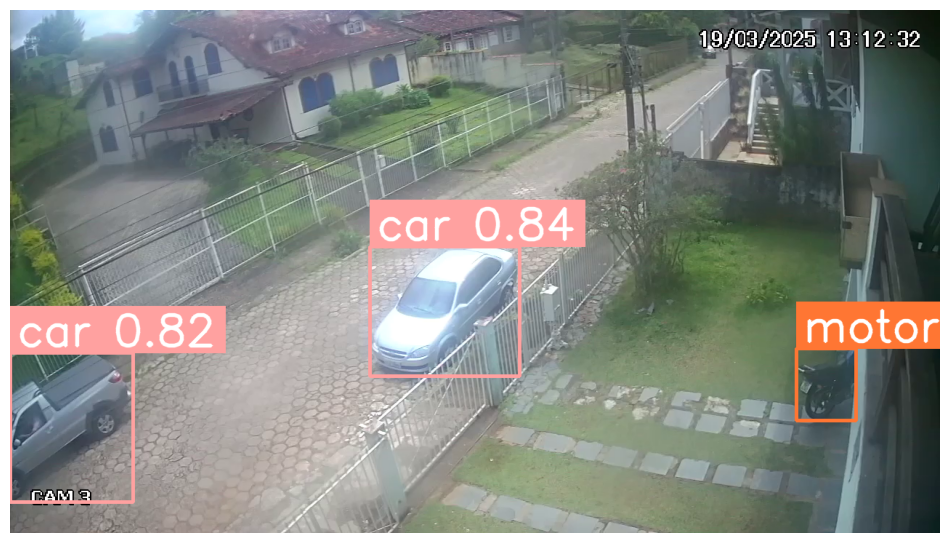

In [24]:
model = YOLO("yolov8s.pt")

generator = sv.get_video_frames_generator(VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
sv.plot_image(annotated_frame, (12, 12))

In [12]:
"detections", len(detections)

('detections', 4)